# Aninmal Shelter - Dog Classification

In [156]:
# Imports
import pandas as pd
import random
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [157]:
labels_path = 'data/labels.csv'
# labels_path = '/kaggle/input/dog-breed-identification/labels.csv'
labels=pd.read_csv(labels_path)

In [158]:
# List of filenames
image_dir = 'data/train/'
# image_dir = '/kaggle/input/dog-breed-identification/train/'
filenames = [os.path.join(image_dir, f"{fname}.jpg") for fname in labels['id']]


# Check if any files do not exist
missing_files = [fname for fname in filenames if not os.path.isfile(fname)]
print(f"Missing files: {len(missing_files)}")

Missing files: 0


In [159]:
# Set variables
X = filenames
y = labels['breed']

In [160]:
# One Hot Encode
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(labels[['breed']])
encoding_labels = encoder.categories_[0]

In [161]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Subset for building
X_train_subset = X_train[:1000]
X_val_subset = X_val[:1000]

## Preprocessing Images - Ruhi

In [162]:
# Parameters for image and batch size
IMG_SIZE = 128
BATCH_SIZE = 32

# PyTorch image transforms - creates a preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #resizes all the images
    transforms.ToTensor(), #converts to tensorflow images
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # converts 0-1 to -1 to 1
])
# Get number of classes
num_classes = len(encoding_labels)

In [163]:
# PyTorch Dataset class
class DogBreedDataset(Dataset):
    #constructor
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
      #determines the length of the dataset
    def __len__(self):
        return len(self.image_paths)
    #called by PyTorch to get a specific item
    def __getitem__(self, idx):
        # Load and process image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Return image and label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label
        

In [164]:
# Convert breed names to numbers
label_encoder = LabelEncoder()
y_train_subset_encoded = label_encoder.fit_transform(y_train[:1000])
y_val_subset_encoded = label_encoder.transform(y_val[:1000])

print(f"Number of classes: {len(label_encoder.classes_)}")

Number of classes: 120


In [165]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [166]:
# Create PyTorch datasets and dataloaders
def create_data_loaders(X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE):
    #Create PyTorch DataLoaders for training and validation"""
    
    # Create datasets
    train_dataset = DogBreedDataset(X_train, y_train, transform)
    val_dataset = DogBreedDataset(X_val, y_val, transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    
    return train_loader, val_loader, train_dataset, val_dataset

In [167]:
# Create PyTorch DataLoaders

# Create training and validation data loaders
train_loader, val_loader, train_dataset, val_dataset = create_data_loaders(
    X_train, 
    y_train_encoded, 
    X_val, 
    y_val_encoded,
    batch_size=BATCH_SIZE
)

# Verify everything is working
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {BATCH_SIZE}")

Training samples: 8177
Validation samples: 2045
Number of classes: 120
Batch size: 32


# EDA - Shipra

Total classes: 120
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64


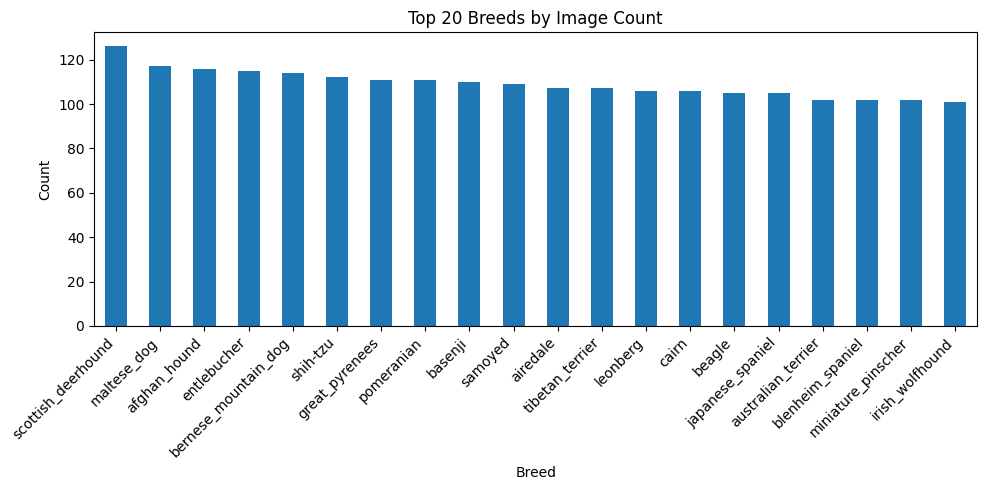

In [168]:
class_counts = labels['breed'].value_counts()
print(f"Total classes: {class_counts.shape[0]}")
print(class_counts.head())

plt.figure(figsize=(10,5))
class_counts.head(20).plot(kind='bar')
plt.title("Top 20 Breeds by Image Count")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Found 10222 existing image files
Sampled 300 images.
Width : mean=440.7, std=184.8, min=112, max=2135
Height: mean=390.5, std=149.8, min=120, max=1720


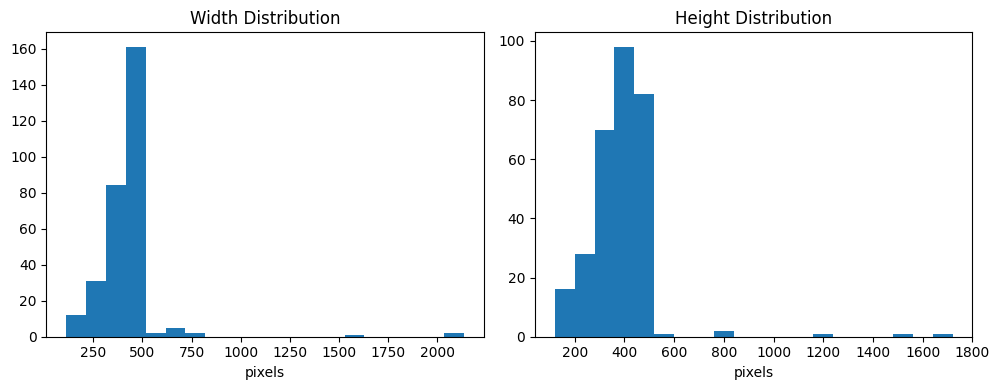

In [169]:
random.seed(42)

existing_files = [f for f in filenames if os.path.exists(f)]
print(f"Found {len(existing_files)} existing image files")

sample_paths = random.sample(existing_files, k=min(300, len(existing_files)))
wh = []

for p in sample_paths:
    try:
        with Image.open(p) as im:
            wh.append(im.size)  # (width, height)
    except Exception as e:
        pass

wh = np.array(wh)

# Checking if we got any valid samples
if len(wh) == 0:
    print("No valid images were read. Check your file paths or extensions (.jpg, .jpeg, .png).")
else:
    
    wh = wh.reshape(-1, 2)
    widths, heights = wh[:, 0], wh[:, 1]
    
    print(f"Sampled {len(wh)} images.")
    print(f"Width : mean={widths.mean():.1f}, std={widths.std():.1f}, min={widths.min()}, max={widths.max()}")
    print(f"Height: mean={heights.mean():.1f}, std={heights.std():.1f}, min={heights.min()}, max={heights.max()}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Width Distribution"); plt.xlabel("pixels")
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Height Distribution"); plt.xlabel("pixels")
    
    plt.tight_layout()
    plt.show()


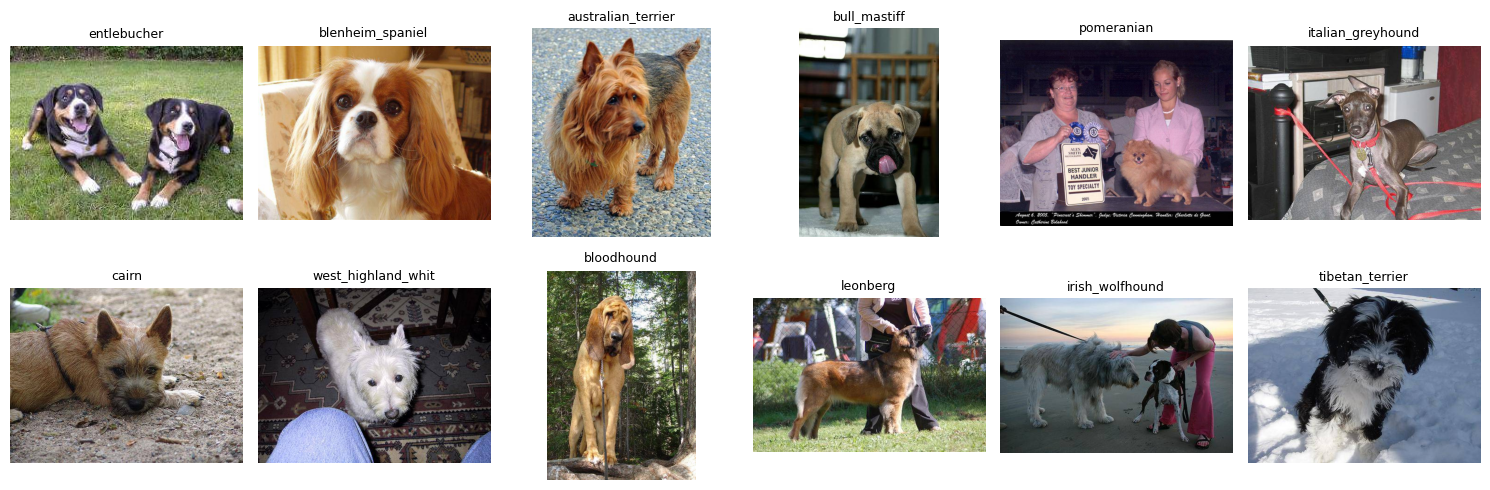

In [170]:
def show_samples(paths, labels_text, n=12, cols=6):
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for i, idx in enumerate(random.sample(range(len(paths)), k=min(n, len(paths)))):
        try:
            img = Image.open(paths[idx]).convert('RGB')
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(str(labels_text[idx])[:18], fontsize=9)
        except:
            continue
    plt.tight_layout()
    plt.show()

# Used original string labels for easier readablity 
show_samples(filenames, labels['breed'].tolist(), n=12, cols=6)


# Base Model - Gururaj

#### Raj if you can explain your thought process

In [171]:
X_train_df = pd.DataFrame(X_train, columns=['filename'])
X_val_df = pd.DataFrame(X_val, columns=['filename'])
train_df = pd.concat([X_train_df, pd.Series(y_train_encoded, name='breed')], axis=1)
val_df = pd.concat([X_val_df, pd.Series(y_val_encoded, name='breed')], axis=1)

In [ ]:
from torch.utils.data import DataLoader

all_breeds = pd.concat([train_df["breed"], val_df["breed"]], axis=0).unique()
breed2idx = {b: i for i, b in enumerate(sorted(all_breeds))}
idx2breed = {i: b for b, i in breed2idx.items()}
num_classes = len(breed2idx)
print("num_classes:", num_classes)

def collate_map(batch):

    images, labels = zip(*batch)
    X = torch.stack(images, dim=0)
    if isinstance(labels[0], str):
        y = torch.tensor([breed2idx[l] for l in labels], dtype=torch.long)
    else:
        y = torch.tensor(labels, dtype=torch.long)
    return X, y

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, collate_fn=collate_map)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, collate_fn=collate_map)
sample_img, sample_lbl = next(iter(train_loader))
print(f"Train batch shape: {sample_img.shape}, Labels shape: {sample_lbl.shape}")



num_classes: 120
Train batch shape: torch.Size([32, 3, 128, 128]), Labels shape: torch.Size([32])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [173]:
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = models.resnet18(weights=None)   
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
print("Model is ready ")


Using device: cpu
Model is ready 


In [174]:
import torch.nn.functional as F
from collections import Counter

counts = Counter([breed2idx[b] for b in train_df["breed"].tolist()])
total  = sum(counts.values())
class_weights = torch.zeros(num_classes, dtype=torch.float)
for c in range(num_classes):
    class_weights[c] = total / (num_classes * counts.get(c, 1))
print("Class weights (first 8):", class_weights[:8])

def ce_loss(outputs, targets, smoothing=0.1, use_weights=False):

    if use_weights:
        return F.cross_entropy(outputs, targets,
                               weight=class_weights.to(device),
                               label_smoothing=smoothing)
    else:
        return F.cross_entropy(outputs, targets, label_smoothing=smoothing)

print("Cross-entropy loss with label smoothing ready")


Class weights (first 8): tensor([1.0647, 0.7327, 1.0324, 0.7743, 1.0816, 0.9735, 0.8850, 0.8210])
Cross-entropy loss with label smoothing ready


In [175]:
import torch.nn.functional as F
from tqdm.auto import tqdm

def run_epoch(loader, train=True, max_batches=None, smoothing=0.1, use_weights=False):
    model.train(train)
    total, correct, running = 0, 0, 0.0

    iterator = tqdm(loader, total=min(len(loader), max_batches) if max_batches else len(loader),
                    desc="train" if train else "valid", leave=False)
    for i, (images, labels) in enumerate(iterator):
        if max_batches is not None and i >= max_batches:
            break

        images, labels = images.to(device), labels.to(device)
        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = ce_loss(outputs, labels,
                           smoothing=(smoothing if train else 0.0),
                           use_weights=use_weights if train else False)
            if train:
                loss.backward()
                optimizer.step()

        running += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        iterator.set_postfix(loss=f"{running/max(total,1):.4f}",
                             acc=f"{correct/max(total,1):.3f}")

    return running / max(total, 1), correct / max(total, 1)

In [176]:
EPOCHS = 50
MAX_TRAIN_BATCHES = 20
MAX_VAL_BATCHES   = 10

history = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True,
                                max_batches=MAX_TRAIN_BATCHES, smoothing=0.1, use_weights=False)
    va_loss, va_acc = run_epoch(val_loader,   train=False,
                                max_batches=MAX_VAL_BATCHES,   smoothing=0.0, use_weights=False)

    # print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
    
    history.append({
        "epoch": epoch,
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "val_loss": va_loss,
        "val_acc": va_acc
    })

print("Epochs complete")

Epochs complete


# Analysis - Annalise

In [ ]:
# Information from most recent run
df_history = pd.DataFrame(history)
df_history.to_csv("training_history.csv", index=False)
display(df_history.head())

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,5.134518,0.010937,6.163926,0.006250
1,2,4.929203,0.021875,4.918985,0.012500
2,3,4.797144,0.031250,4.790159,0.021875
3,4,4.699949,0.040625,5.087500,0.018750
4,5,4.697390,0.021875,4.802255,0.034375


### Basic Model

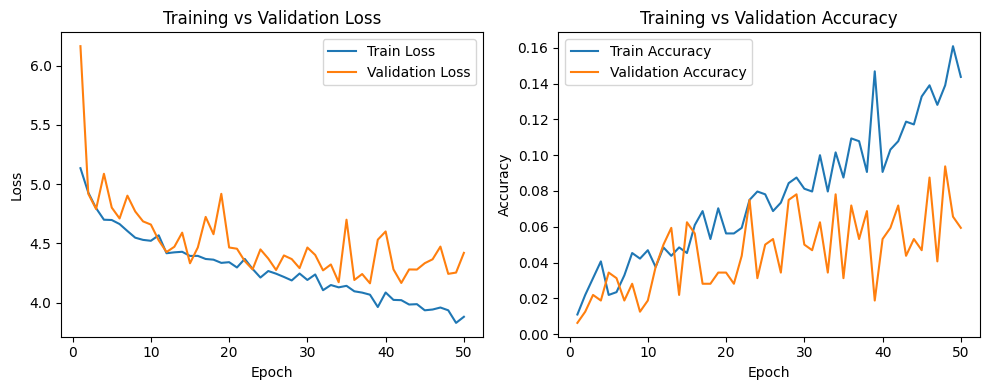

In [ ]:
basic_model = pd.read_csv("training_history_basic_model.csv")

# Plot Loss Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(basic_model['epoch'], basic_model['train_loss'], label='Train Loss')
plt.plot(basic_model['epoch'], basic_model['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(basic_model['epoch'], basic_model['train_acc'], label='Train Accuracy')
plt.plot(basic_model['epoch'], basic_model['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Final Model

# Animal Shelter Application - Jahneulie